In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #

# Evacuation Data
evacdata = pd.read_csv('./output_new3/run_no/gy-evac run_no-table.csv', skiprows=6).sort_values(by=['[run number]', 'ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata['run_number'] = evacdata['run_number'] - 1

# Journey Time Data
jm_files = glob.glob('./output_new3/run_no/jm*.csv')
journey_metrics_list = [pd.read_csv(file) for file in jm_files]
# Extract run number from file names and add as a column to each dataframe
for i, file in enumerate(jm_files):
    run_number = int(file.split('_')[-1].split('.')[0])
    journey_metrics_list[i]['run_number'] = run_number
# Concatenate the dataframes
journey_metrics = pd.concat(journey_metrics_list, ignore_index=True).sort_values(by=['run_number', 'start_tick'])

# calculate normalised journey time
journey_metrics['ideal_time'] = journey_metrics['ideal_time'] * 60
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3


# calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_time_minutes'].max() + -45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['run_number', 'start_time_bin'])['normalised_journey_time'].mean().reset_index()



In [59]:
evacdata.head()

,run_number,terminate_evac_distance_km,initial_people,max_walking_distance_km,warning_interval_time_mins,evacuation_probability,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes
0,0,0.3,15000,1,30,0.3,0.3,0.1,0,0,0,0,0,0,0,0.000000,0.0
1,0,0.3,15000,1,30,0.3,0.3,0.1,1,1,1113,434,4509,5,4075,3.661276,0.3
2,0,0.3,15000,1,30,0.3,0.3,0.1,2,2,1109,424,4486,28,4062,3.662759,0.6
3,0,0.3,15000,1,30,0.3,0.3,0.1,3,3,1101,412,4445,69,4033,3.663034,0.9
4,0,0.3,15000,1,30,0.3,0.3,0.1,4,4,1085,406,4382,132,3976,3.664516,1.2


In [51]:
mean_normalised_journey_time_per_bin_per_run.head()

,run_number,start_tick_bin,normalised_journey_time
0,0,"(0, 120]",46.933691
1,0,"(120, 240]",61.799350
2,0,"(240, 360]",73.240624
3,0,"(360, 480]",81.517397
4,0,"(480, 600]",90.412052


In [120]:
journey_metrics.head()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,run_number,normalised_journey_time,start_tick_bin
25607,10162,0,0.8500,0.25,0,0,0,0.294118,NaN
25608,1520,4,0.8500,0.75,0,2,0,0.882353,NaN
25609,15549,1,0.9350,0.75,0,2,0,0.802139,NaN
25610,7368,4,0.9375,1.00,0,3,0,1.066667,NaN
25611,9921,5,0.9800,1.00,0,3,0,1.020408,NaN


# NORMALISED JOURNEY TIME

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


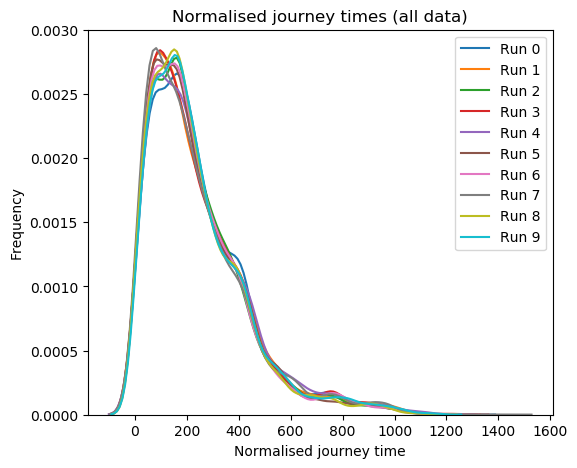

In [23]:
# NORMALISED JOURNEY TIMES HISTOGRAM

fig, ax = plt.subplots(figsize=(6, 5))
for run in journey_metrics['run_number'].unique():
    sns.kdeplot(journey_metrics[journey_metrics['run_number'] == run]['normalised_journey_time'], label=f'Run {run}')
ax.legend()
ax.set_title('Normalised journey times (all data)')
ax.set_xlabel('Normalised journey time')
ax.set_ylabel('Frequency')
#ax.set_xscale('log')

plt.show()

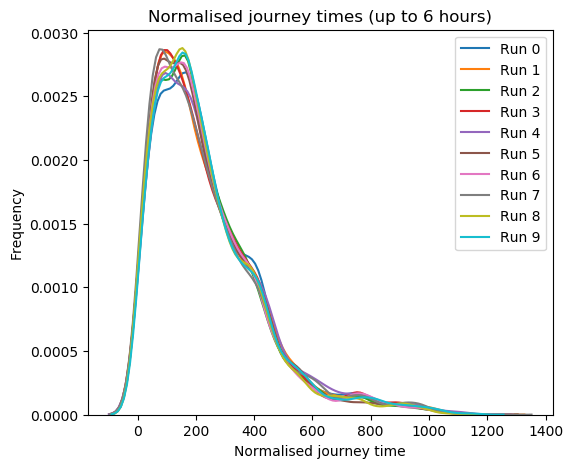

In [24]:
# NORMALISED JOURNEY TIMES HISTOGRAM UP TO 6 HOURS ONLY

fig, ax = plt.subplots(figsize=(6, 5))
for run in journey_metrics['run_number'].unique():
    sns.kdeplot(journey_metrics[(journey_metrics['run_number'] == run) & (journey_metrics['start_tick'] < 1440)]['normalised_journey_time'], label=f'Run {run}')
ax.legend()
ax.set_title('Normalised journey times (up to 6 hours)')
ax.set_xlabel('Normalised journey time')
ax.set_ylabel('Frequency')
#ax.set_xscale('log')

plt.show()

In [71]:
# Claculating statistics on normalised journey time (all data)
journey_metrics_stats_all = journey_metrics.groupby('run_number')['normalised_journey_time'].agg(['mean', 'std', 'max', 'min']).reset_index()
journey_metrics_stats_all['skew'] = journey_metrics.groupby('run_number')['normalised_journey_time'].apply(stats.skew).values

print(journey_metrics_stats_all)

   run_number       mean        std         max       min      skew
0           0  67.070861  57.704182  488.443396  0.294118  1.499258
1           1  65.260098  56.148024  505.424528  0.234192  1.532087
2           2  66.486850  56.447773  532.030265  0.234192  1.528070
3           3  65.842938  55.444602  455.250597  0.294118  1.449706
4           4  63.978681  54.743076  518.750000  0.234192  1.646912
5           5  64.638729  55.037261  602.225313  0.234192  1.599344
6           6  64.493310  54.874667  487.549407  0.294118  1.451156
7           7  64.754729  54.887259  500.695410  0.234192  1.538784
8           8  66.361872  57.140967  475.652174  0.234192  1.555694
9           9  64.961808  56.468232  457.228916  0.294118  1.527954


In [15]:
# Calculating statistics on normalised journey time (up to 6 hours only)
journey_metrics_filtered = journey_metrics[journey_metrics['start_tick'] < 1440]
journey_metrics_stats = journey_metrics_filtered.groupby('run_number')['normalised_journey_time'].agg(['mean', 'std', 'max', 'min']).reset_index()
journey_metrics_stats['skew'] = journey_metrics_filtered.groupby('run_number')['normalised_journey_time'].apply(stats.skew).values

print(journey_metrics_stats)

   run_number          mean           std           max         min      skew
0           0  14514.608136  11225.390563  70977.687627  142.292490  1.410075
1           1  14239.700103  11372.987754  73743.396226  177.646188  1.456268
2           2  13942.029967  10826.972781  72669.371197  164.383562  1.437211
3           3  14197.086305  11315.228881  72407.547170   92.130518  1.447079
4           4  14745.065554  11634.144804  70259.634888  168.126095  1.412280
5           5  13850.759989  10848.191928  71172.413793  185.614849  1.447484
6           6  13946.004379  10919.399093  71756.592292   92.130518  1.456017
7           7  14069.043687  11480.742930  75237.735849  123.853211  1.475414
8           8  13794.281943  10722.608772  66245.136187  116.004296  1.450179
9           9  14320.077198  11207.520406  69833.810888  164.383562  1.513719


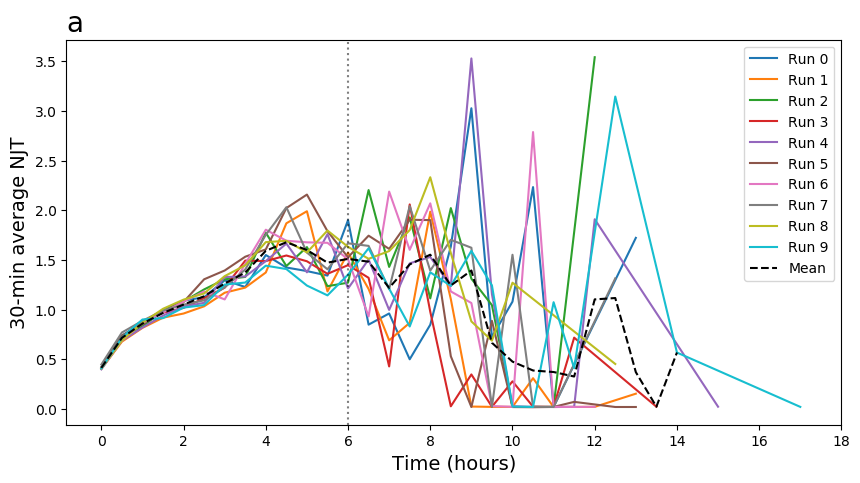

In [75]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each run
for run in mean_normalised_journey_time_per_bin_per_run['run_number'].unique():
    run_data = mean_normalised_journey_time_per_bin_per_run[mean_normalised_journey_time_per_bin_per_run['run_number'] == run]
    start_tick_midpoints = run_data['start_time_bin'].apply(lambda x: x.mid)
    plt.plot(np.array(start_tick_midpoints), run_data['normalised_journey_time'], label=f'Run {run}')

# Calculate mean and standard deviation
mean_values = mean_normalised_journey_time_per_bin.groupby('start_time_bin')['normalised_journey_time'].mean()
std_values = mean_normalised_journey_time_per_bin.groupby('start_time_bin')['normalised_journey_time'].std()

# Plot mean
plt.plot(mean_values.index.categories.mid, mean_values, 'k--', label='Mean')

# Plot shaded area for standard deviation
plt.fill_between(mean_values.index.categories.mid, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.2)

ax.legend()
ax.set_title('a', loc='left', fontsize=20)
ax.set_ylabel('30-min average NJT', fontsize=14)
ax.set_xlabel('Time (hours)', fontsize=14)
ax.axvline(x=360, color='k', linestyle='dotted', alpha=0.5)
#ax.annotate('6 hours', xy=(360, ax.get_ylim()[1]), xytext=(360, ax.get_ylim()[1] * 0.9), fontsize=14)
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840, 960, 1080])
ax.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])

plt.savefig('figures_v02/run_number_njt_timeseries.png')

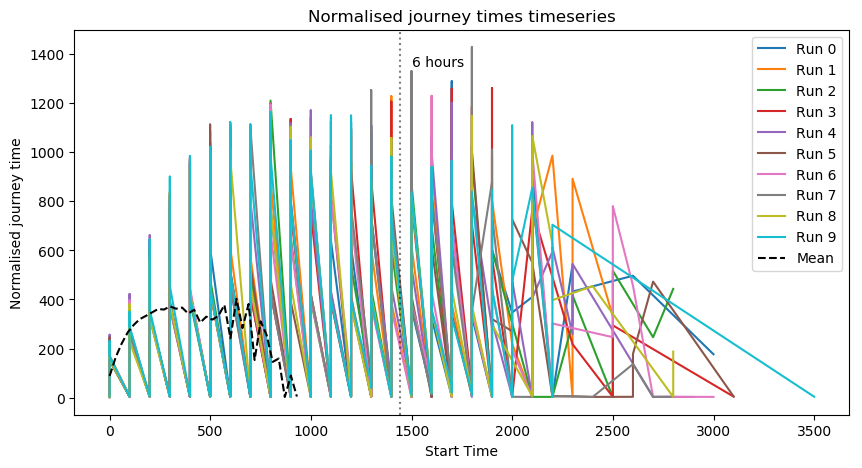

In [26]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each run
for run in mean_normalised_journey_time_per_bin_per_run['run_number'].unique():
    run_data = journey_metrics[journey_metrics['run_number'] == run]
    plt.plot(run_data['start_tick'], run_data['normalised_journey_time'], label=f'Run {run}')

# Calculate mean and standard deviation
mean_values = mean_normalised_journey_time_per_bin.groupby('start_time_bin')['normalised_journey_time'].mean()
std_values = mean_normalised_journey_time_per_bin.groupby('start_time_bin')['normalised_journey_time'].std()

# Plot mean
plt.plot(mean_values.index.categories.mid, mean_values, 'k--', label='Mean')

# Plot shaded area for standard deviation
plt.fill_between(mean_values.index.categories.mid, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.2)

ax.legend()
ax.set_title('Normalised journey times timeseries')
ax.set_ylabel('Normalised journey time')
ax.set_xlabel('Start Time')
ax.axvline(x=1440, color='k', linestyle='dotted', alpha=0.5)
ax.annotate('6 hours', xy=(1440, ax.get_ylim()[1]), xytext=(1500, ax.get_ylim()[1] * 0.9))

plt.show()

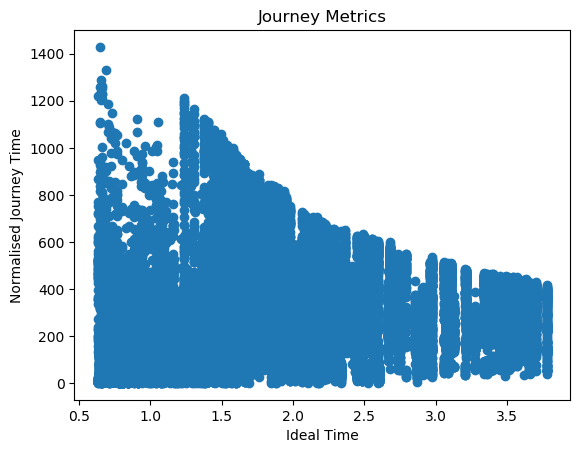

In [29]:
plt.subplots()

plt.scatter(journey_metrics['ideal_time'], journey_metrics['normalised_journey_time'])

plt.xlabel('Ideal Time')
plt.ylabel('Normalised Journey Time')
plt.title('Journey Metrics')
plt.show()

### INTERPRETATIONS

- the normalised journey times are negatively skewed, but have some very high maximum values
- the model runs are fairly consistent in the temporal evolution of the normalised journey time until about 1000 ticks (4 hours),  after which model behaviour is chaotic (less predictable), unstable
- 1 in 5 runs displayed "tipping point" behavour (Runs 4 and 5) with extremely high journey time spikes between 2500 - 3000 ticks
- but we should cut it off after about 6 hours (1440 ticks) anyway?


CONCLUSION: if simulation is ran for less than 6 hours, given computation constaints, one run can be representative of overall model behaviour for traffic

# EVAUCUATED AND EVACUATING PEOPLE

   run_number  get_no_evacuated
0           1              6336
1           2              6284
2           3              6208
3           4              6365
4           5              6396
5           6              6328
6           7              6122
7           8              6302
8           9              6353
9          10              6373


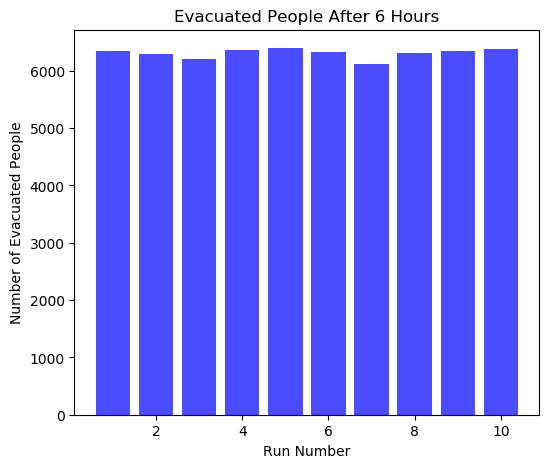

mean    6306.700000
std       84.075429
max     6396.000000
min     6122.000000
skew      -1.170303
Name: get_no_evacuated, dtype: float64


In [119]:
evacuated_at_6hours = evacdata[evacdata['ticks'] == 1440].groupby('run_number')['get_no_evacuated'].sum().reset_index()
print(evacuated_at_6hours)

fig, ax = plt.subplots(figsize=(6, 5))
# ax.hist(evacuated_at_6hours['get_no_evacuated'], bins=10, density=True, alpha=0.6, color='g')
ax.bar(evacuated_at_6hours['run_number'], evacuated_at_6hours['get_no_evacuated'], color='b', alpha=0.7)
ax.set_title('Evacuated People After 6 Hours')
ax.set_ylabel('Number of Evacuated People')
ax.set_xlabel('Run Number')
plt.show()

evacuated_stats = evacuated_at_6hours['get_no_evacuated'].agg(['mean', 'std', 'max', 'min'])
evacuated_stats['skew'] = stats.skew(evacuated_at_6hours['get_no_evacuated'])
print(evacuated_stats)

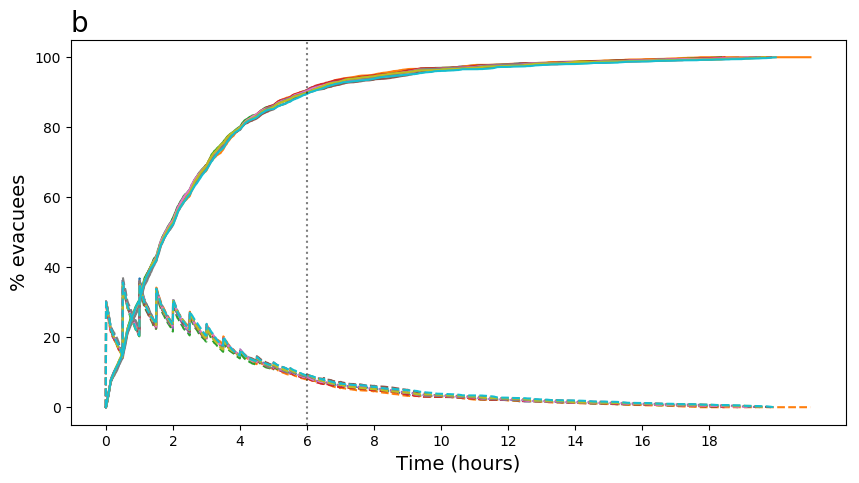

In [74]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each run
for run in evacdata['run_number'].unique():
    run_data = evacdata[evacdata['run_number'] == run]
    ax.plot(run_data["time_minutes"], run_data['get_no_evacuated']/run_data['initial_people'] * 100, label=f'Run {run}')
    ax.plot(run_data["time_minutes"], run_data['get_no_evacuating']/run_data['initial_people'] * 100, linestyle='--', color=ax.get_lines()[-1].get_color())

# # Calculate mean and standard deviation
# mean_values = evacdata.groupby('')['get_no_evacuated'].mean()
# std_values = evacdata.groupby('ticks')['get_no_evacuated'].std()

# # Plot mean
# plt.plot(mean_values.index.categories.mid, mean_values, 'k--', label='Mean')

# # Plot shaded area for standard deviation
# plt.fill_between(mean_values.index.categories.mid, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.2)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_title('b', loc='left', fontsize=20)
ax.set_ylabel('% evacuees', fontsize=14)
ax.set_xlabel('Time (hours)', fontsize=14)
ax.axvline(x=360, color='k', linestyle='dotted', alpha=0.5)
#ax.annotate('6 hours', xy=(360, ax.get_ylim()[1]), xytext=(360, ax.get_ylim()[1] * 0.9))
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840, 960, 1080])
ax.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])

plt.savefig('figures_v02/run_number_evac_timeseries.png')

In [60]:
evacdata['run_number'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


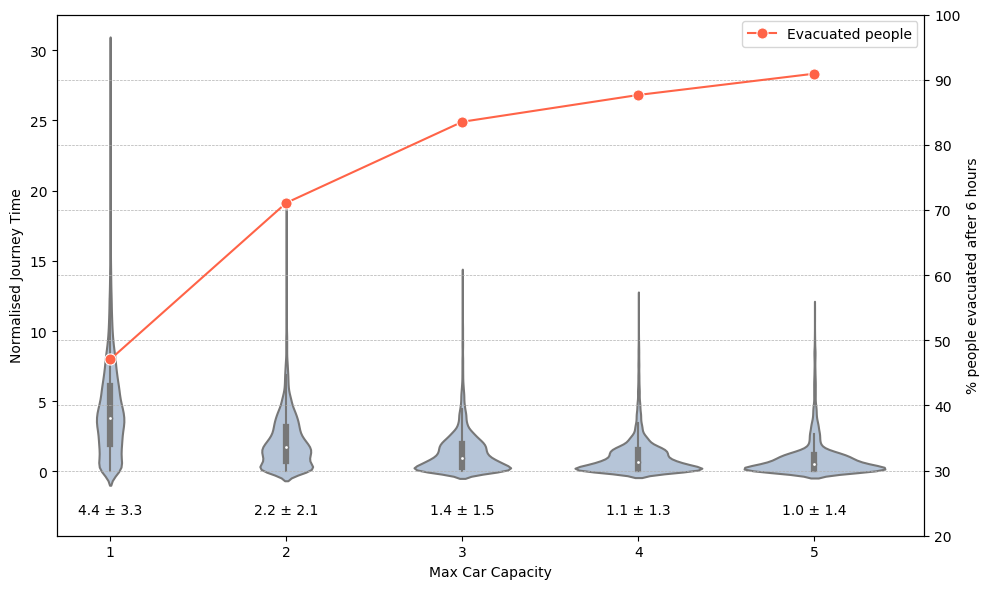

In [ ]:
evacdata['car_capacity-1'] = evacdata['car_capacity'] - 1
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=journey_metrics, x="car_capacity", y="normalised_journey_time", color='lightsteelblue', ax=ax, label='Normalised Journey Time')
ax.set_ylabel('Normalised Journey Time')

# Get the x positions of the violin plots
x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
ax.set_xlabel('Max Car Capacity')

ax2 = ax.twinx()
sns.lineplot(data=evacdata[evacdata['time_minutes'] == 360], x='car_capacity-1', y='evacuated_perc', color='tomato', ax=ax2, markers=True, marker='o', markersize=8, label='Evacuated people')

ax2.set_ylabel('% people evacuated after 6 hours')

# Create a combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
ax2.set_ylim(20, 100)

# Calculate mean and standard deviation for each violin
means = journey_metrics.groupby('car_capacity')['normalised_journey_time'].mean()
stds = journey_metrics.groupby('car_capacity')['normalised_journey_time'].std()

# Offset the start of the y axis to make room for annotations
ax.set_ylim(bottom=ax.get_ylim()[0] - 2)

# Annotate mean and standard deviation
for i, evp in enumerate(means.index):
    mean = means[evp]
    std = stds[evp]
    ax.text(i, -3, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)

ax2.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./figures_v02/njt_evac_violin_carsharing.png')

^ solid lines are the evacuated people, dashed lines are the evacuating people

### INTERPRETATION

- the temporal evoluaiton of the evacuated and evacuating people is fairly consistnet between models, even after a lots of time has elasped, dispite the unstable behaviour exhibited by the normalised journey time
- the number of people evacuated after 6 hours is very simular across models, with a mean of 6306 and standard deviation of only 84 (only 1.3% of the mean)
- we may want to extend the time frame we look at to more than 6 hours so we can see more how the evacuees behave over time
- the instability in the normalised journey time seems to occur almost exactly when the no evacuated people overtakes the no-people evacuating. Coincidence? Hard to tell without more runs at different configs.
- One run, given the computational load of running more, should suffice to represent evacuee behaviour